In [4]:
import numpy
import pandas
import scipy.signal

from matplotlib import pyplot as plt

## Example problem

We use as an example a system which can be either ON or OFF, or moving between these two states.



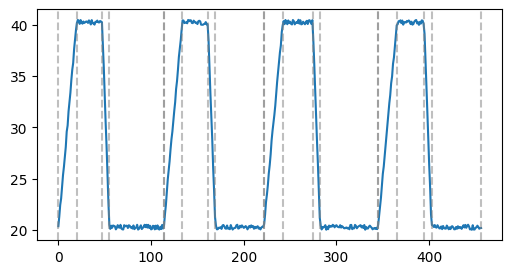

In [108]:
def make_period(on=1, off=1, starting=0, stopping=0):
    """
      x1   x2
      .------         .
     .       .       .
    -         -------
    |x0      x3    x4|
    
    """
    
    x0 = 0
    x1 = x0+starting
    x2 = x1+on
    x3 = x2+stopping
    x4 = x3+off
    
    xs = numpy.array([x0, x1, x2, x3, x4])
    ys = numpy.array([ 0,  1,  1,  0,  0])
    ss = numpy.array([0, 1, 2, 3, 4])
    
    return xs, ys, ss

def add_whitenoise(x, amplitude=1.0):
    n = amplitude * numpy.random.random(size=len(x))
    return x + n

def make_many(periods=2, off_level=10, on_level=40, noise=3):
    start = scipy.stats.norm(loc=20, scale=0.3)
    stop = scipy.stats.norm(loc=8, scale=0.3)
    on = scipy.stats.norm(loc=30, scale=3)
    off = scipy.stats.norm(loc=60, scale=5)
    
    starts = start.rvs(periods)
    stops = stop.rvs(periods)
    ons = on.rvs(periods)
    offs = off.rvs(periods)
    
    xs = []
    ys = []
    ms = []
    x = 0
    for p in range(periods):
        xx, yy, ss = make_period(on=ons[p], off=offs[p], starting=starts[p], stopping=stops[p])
        xx += x # shift forward based on where we are
        x = xx[-1]
        xs = numpy.concatenate([xs, xx])
        ys = numpy.concatenate([ys, yy])
        for t,s in zip(xx, ss):
            ms.append(t)
        
    t = numpy.arange(xs[0], xs[-1])
    xx = numpy.interp(t, xs, ys)
    
    height = on_level-off_level
    xx *= height
    xx += off_level
    xx = add_whitenoise(xx, amplitude=noise)
    
    return t, xx, ms

# TODO: also return ground-truth about states

x, y, m = make_many(periods=4, on_level=40, off_level=20, noise=0.5)
fig, ax = plt.subplots(1, figsize=(6,3))
ax.plot(x, y)
    
def plot_markers(ax, locations):
    for v in locations:
        ax.axvline(v, ls='--', alpha=0.5, color='grey')

plot_markers(ax, m)

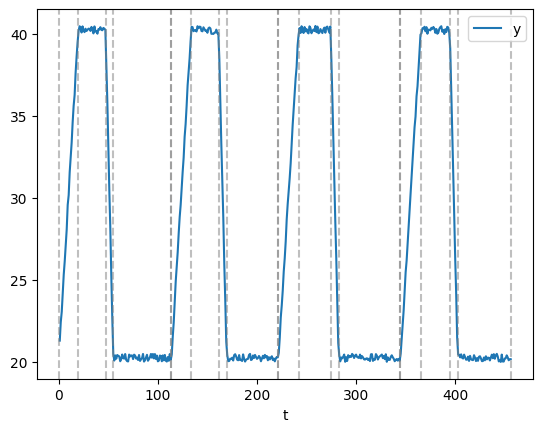

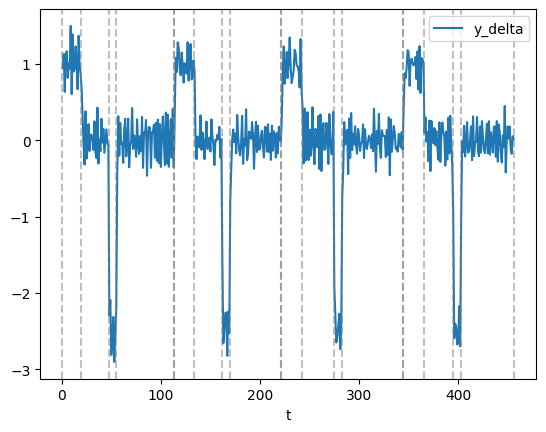

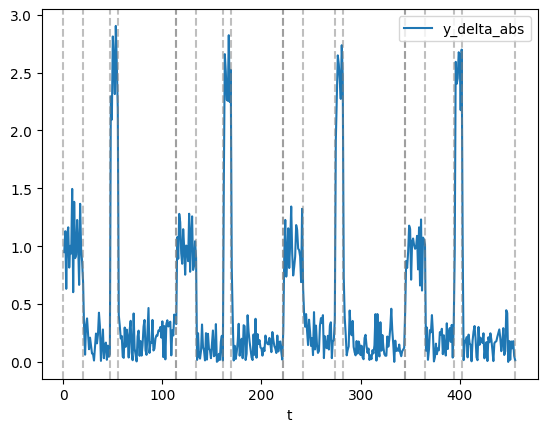

In [109]:

f = pandas.DataFrame({
    't': x,
    'y': y,
}).set_index('t')

# XXX: if the noise value is higher, then delta features do not separate transitions from steady well. Must compute over longer window
f['y_delta'] = f['y'].diff(1) 
f['y_delta_abs'] = f['y_delta'].abs() 
f = f.dropna()
ax = f.plot(y='y')
plot_markers(ax, m)
ax = f.plot(y=['y_delta'])
plot_markers(ax, m)
ax = f.plot(y=['y_delta_abs'])
plot_markers(ax, m)

<AxesSubplot:ylabel='Density'>

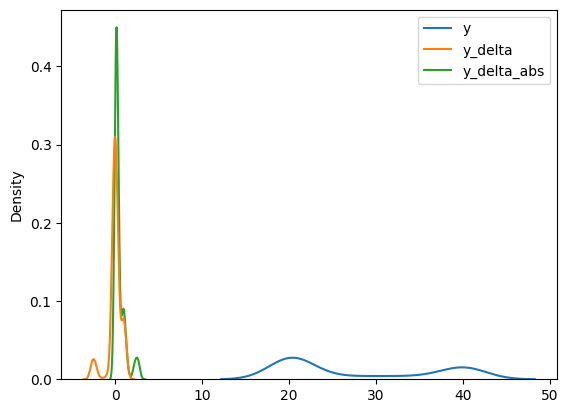

In [110]:
import seaborn
seaborn.kdeplot(data=f)

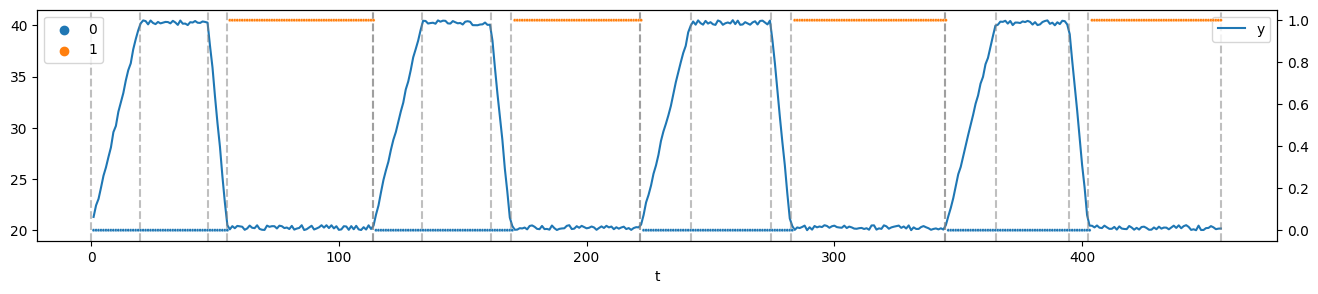

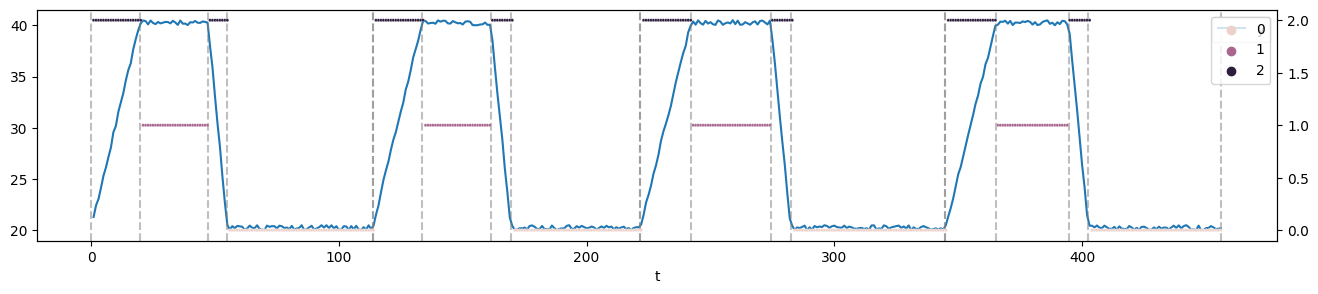

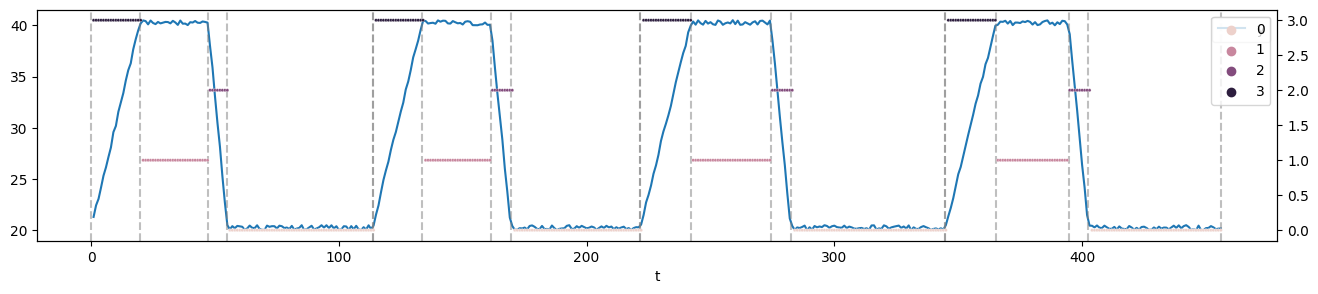

In [115]:
from hmmlearn import hmm

models = {
    '2states': hmm.GaussianHMM(n_components=2, covariance_type="full"),
    '3states': hmm.GaussianHMM(n_components=3, covariance_type="full"),
    '4states': hmm.GaussianHMM(n_components=4, covariance_type="full"),
}
features = [
    'y',
    #'y_delta_abs',
    'y_delta',
]
def format_sequence_hmmlearn(s):
    #print(s.shape)
    return s

for name, model in models.items():
    
    X = f[features]
    model.fit(format_sequence_hmmlearn(X))

    scores = model.score_samples(format_sequence_hmmlearn(X))[1]
    #print(scores)
    states = numpy.argmax(scores, axis=1)
    #print(states)
    
    fig, ax = plt.subplots(1, figsize=(16,3))
    ax2 = ax.twinx()
    
    # TODO: sort states before plotting
    # TODO: add names to states
    f.plot(ax=ax, y='y')
    seaborn.scatterplot(ax=ax2, x=X.index, y=states, hue=states, s=5)
    plot_markers(ax, m)
    #pandas.Series(states).plot.scatter(x=X.index, y=)

# TODO: plot the states and transitions. Graphviz / transition matrix with zeroes downplayed
# TODO: plot the component distributions. 1d, 2d, separately/jointly


In [112]:
import pandas
import io
models = pandas.read_csv(io.StringIO("""
on,off,starting,stopping,name
1,1,0,0,"NoTransitions"
1,1,1,0,"StartingOnly"
1,1,0,1,"StoppingOnly"
1,1,1,1,"StartingStopping"
1,1,2,0,"MultiStartNoStop"
""")).set_index('name')
models

# FIXME: also add a CommonTransition model, where the transition state is same for starting and stopping


,on,off,starting,stopping
name,,,,
NoTransitions,1,1,0,0
StartingOnly,1,1,1,0
StoppingOnly,1,1,0,1
StartingStopping,1,1,1,1
MultiStartNoStop,1,1,2,0


## hmmlearn implementation

In [116]:
import hmmlearn.hmm

class ConstrainedGaussianHMM(hmmlearn.hmm.GaussianHMM):
    def _do_mstep(self, stats):
        
        # do the standard HMM learning step
        super()._do_mstep(stats)
        
        # find which states are where
        # we name them based on their typical value
        m = numpy.squeeze(self.means_)
        s = numpy.argsort(m)
        s1, s2, s3 = s
        
        # constrain the transition matrix
        # disallow s1->s2 and/or s2->s3 is not allowed
        self.transmat_[s1,s2] = 0.0
        self.transmat_[s2,s3] = 0.0
